## prepare

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Please enter your LangSmith API key: ")


In [ ]:
import getpass
import os

if not os.environ.get("DEEPSEEK_API_KEY"):
#   os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("deepseek_api_key")

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [8]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

## indexing

In [10]:
!pip install bs4

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

   ------------- -------------------------- 1/3 [beautifulsoup4]
   ------------- -------------------------- 1/3 [beautifulsoup4]
   ---------------------------------------- 3/3 [bs4]



In [11]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [12]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [14]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['642c28d8-66f4-4868-9d26-282c735a7839', '85a89f8d-e90f-4c9e-a90f-63d50760db1e', '9e34770d-f2b9-4ba1-90c9-963517281730']


## retrieval and generation

In [15]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [16]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

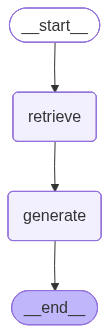

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
result = graph.invoke({"question": "What is Function Call?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='779df2a7-e4a5-4cfd-a8f1-8dcdb5a05308', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34657}, page_content='You always add a comment briefly describing the purpose of the function definition.\nYou try to add comments explaining very complex bits of logic.\nYou always follow the best practices for the requested languages in terms of describing the code written as a defined\npackage/project.\nPython toolbelt preferences:'), Document(id='625291cd-efca-488e-8823-eee9e46b93c3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 28840}, page_content='11. Delete file: "delete_file", args: "file": "<file>"\n12. Search Files: "search_files", args: "directory": "<directory>"\n13. Analyze Code: "analyze_code", args: "code": "<full_code_string>"\n14. Get Improved Code: "improve_code", args: "suggestions": "<list_of_suggestions>", "code": "<full_code_string>"\n15. Write Tests: "write_tests", a

In [22]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='443feffd-e935-4aef-a423-9cc204776d1b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

In [23]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| a| technique| for| breaking| down| complex| tasks| into| smaller|,| manageable| subt|asks|.| It| can| be| achieved| through| methods| like| LL|M| prompting|,| task|-specific| instructions|,| or| human| input|.| This| process| is| a| key| component| of| planning| in| AI| systems| to| handle| complicated| requests|.||